In [405]:
%%html
<style>
table {float:left}
</style>

# Analyzing-Network-Traffic_kdd99

### EDA / Data Cleaning / Hypothesis Tests

In [408]:
# my python files
import src.analytics as tics
import src.plotting_functions as pltfuncs
import src.transforms as trans
import src.hyp_test as hyp

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [407]:
# On OSX requires brew install coreutils, using gshuf instead of shuf
sample_name = 'data/sample_random_subset.csv'

tics.create_random_samples('data/kddcup.data', 700000, sample_name)

### Get some Initial metrics

##### As the name list that accompanies the data set did not have all the field names, I cross referenced with a `sql` file at https://github.com/myui/hivemall/wiki/KDD-cup-1999-network-intrusion-dataset-%231 .  This matched the order displayed with the data set as well as with other tables out on the webs.

In [409]:
df = trans.read_data(sample_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 42 columns):
duration                       700000 non-null int64
protocol_type                  700000 non-null object
service                        700000 non-null object
flag                           700000 non-null object
src_bytes                      700000 non-null int64
dst_bytes                      700000 non-null int64
land                           700000 non-null int64
wrong_fragment                 700000 non-null int64
urgent                         700000 non-null int64
hot                            700000 non-null int64
num_failed_logins              700000 non-null int64
logged_in                      700000 non-null int64
num_compromised                700000 non-null int64
root_shell                     700000 non-null int64
su_attempted                   700000 non-null int64
num_root                       700000 non-null int64
num_file_creations             700000 

In [410]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,700000.000000,7.000000e+05,7.000000e+05,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,...,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,48.410279,9.165166e+02,3.124506e+03,0.000004,0.000627,0.000007,0.012717,0.000029,0.143700,0.020603,...,232.911707,189.090674,0.753127,0.030825,0.604457,0.006468,0.178640,0.178391,0.057883,0.057574
std,714.331030,2.943794e+04,1.637229e+06,0.002070,0.042033,0.003586,0.480956,0.006969,0.350786,9.176576,...,64.088760,105.965121,0.411482,0.108876,0.481111,0.041033,0.382294,0.382603,0.230844,0.230755
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,48.000000,0.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.050000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42723.000000,7.670332e+06,1.309937e+09,1.000000,3.000000,2.000000,30.000000,3.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [412]:
df['label'].value_counts()

smurf.              400720
neptune.            153505
normal.             139294
satan.                2265
ipsweep.              1792
portsweep.            1450
nmap.                  326
back.                  296
warezclient.           154
teardrop.              134
pod.                    40
guess_passwd.            9
buffer_overflow.         5
ftp_write.               2
warezmaster.             2
land.                    2
perl.                    1
rootkit.                 1
imap.                    1
loadmodule.              1
Name: label, dtype: int64

##### Observe uniques for each object type

In [414]:
unique_vals_per_column = tics.count_column_uniques(df)

# for k, v in unique_vals_per_column.items():
#     print('{}: {}\n'.format(k, v))

##### Count number of zero values in each column

The motivation here is to see if which of the features are contributing little to the y

In [415]:
zero_counts = tics.count_zeros_ratio(df)
# zero_counts

In [250]:
print(tics.count_zeros_message(df))

At 700000 samples:
   land has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values



```
At 1000 samples:
   land has only zero values
   urgent has only zero values
   num_failed_logins has only zero values
   root_shell has only zero values
   su_attempted has only zero values
   num_root has only zero values
   num_shells has only zero values
   num_access_files has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values

At 10000 samples:
   land has only zero values
   urgent has only zero values
   num_failed_logins has only zero values
   root_shell has only zero values
   su_attempted has only zero values
   num_shells has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values
   
At 50000 samples:
   su_attempted has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values
   
At 250000 samples:
   urgent has only zero values
   num_outbound_cmds has only zero values
   is_host_login has only zero values
 
At 500000 samples:
   num_outbound_cmds has only zero values
   is_host_login has only zero values
   
At 700000 samples:
   num_outbound_cmds has only zero values
```

### Some Histograms

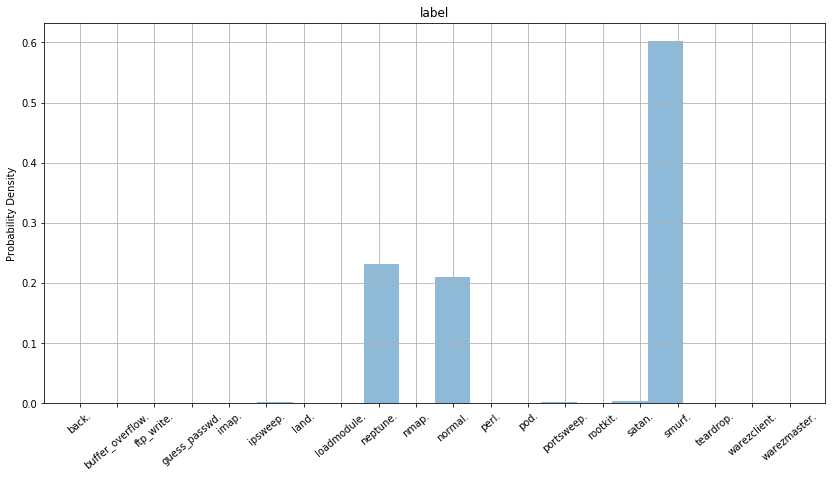

In [416]:
pltfuncs.plot_hist_basic(df, 'label')

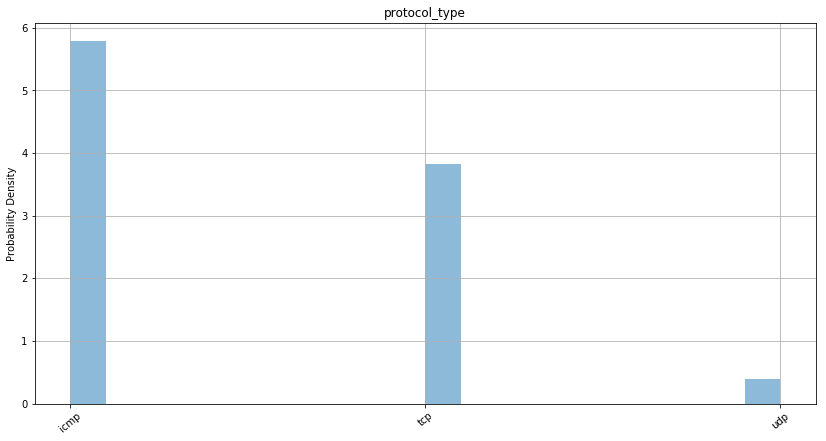

In [252]:
pltfuncs.plot_hist_basic(df, 'protocol_type')

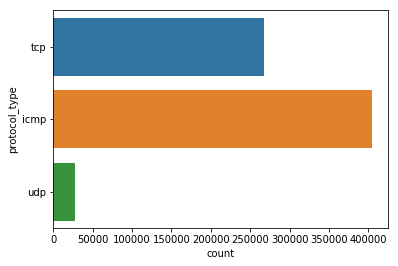

In [253]:
sns_plt = sns.countplot(y=df["protocol_type"])

In [254]:
df['protocol_type'].value_counts()

icmp    405033
tcp     267370
udp      27597
Name: protocol_type, dtype: int64

### ICMP
(from wikipedia): is used by network devices, including routers, to send error messages and operational information indicating, for example, that a requested service is not available or that a host or router could not be reached. ICMP differs from transport protocols such as TCP and UDP in that it is not typically used to exchange data between systems, nor is it regularly employed by end-user network applications


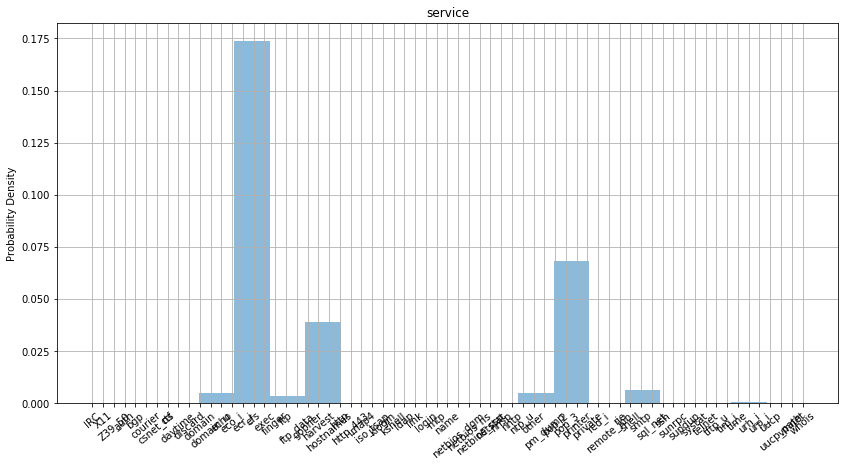

In [428]:
pltfuncs.plot_hist_basic(df, 'service')

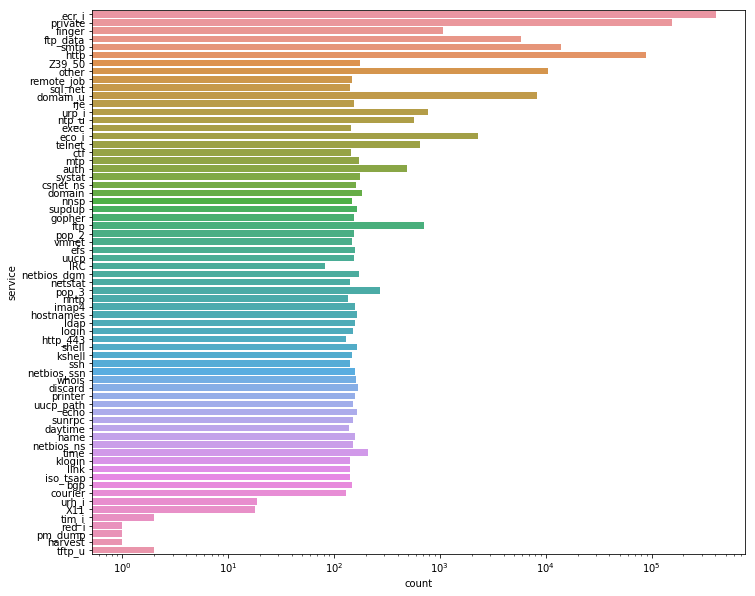

In [429]:
dims = (11.7, 10)
fig, ax = plt.subplots(figsize=dims)

g = sns.countplot(ax=ax,
                        y=df["service"])
ax.set_xscale('log')

In [430]:
# df['service'].value_counts();

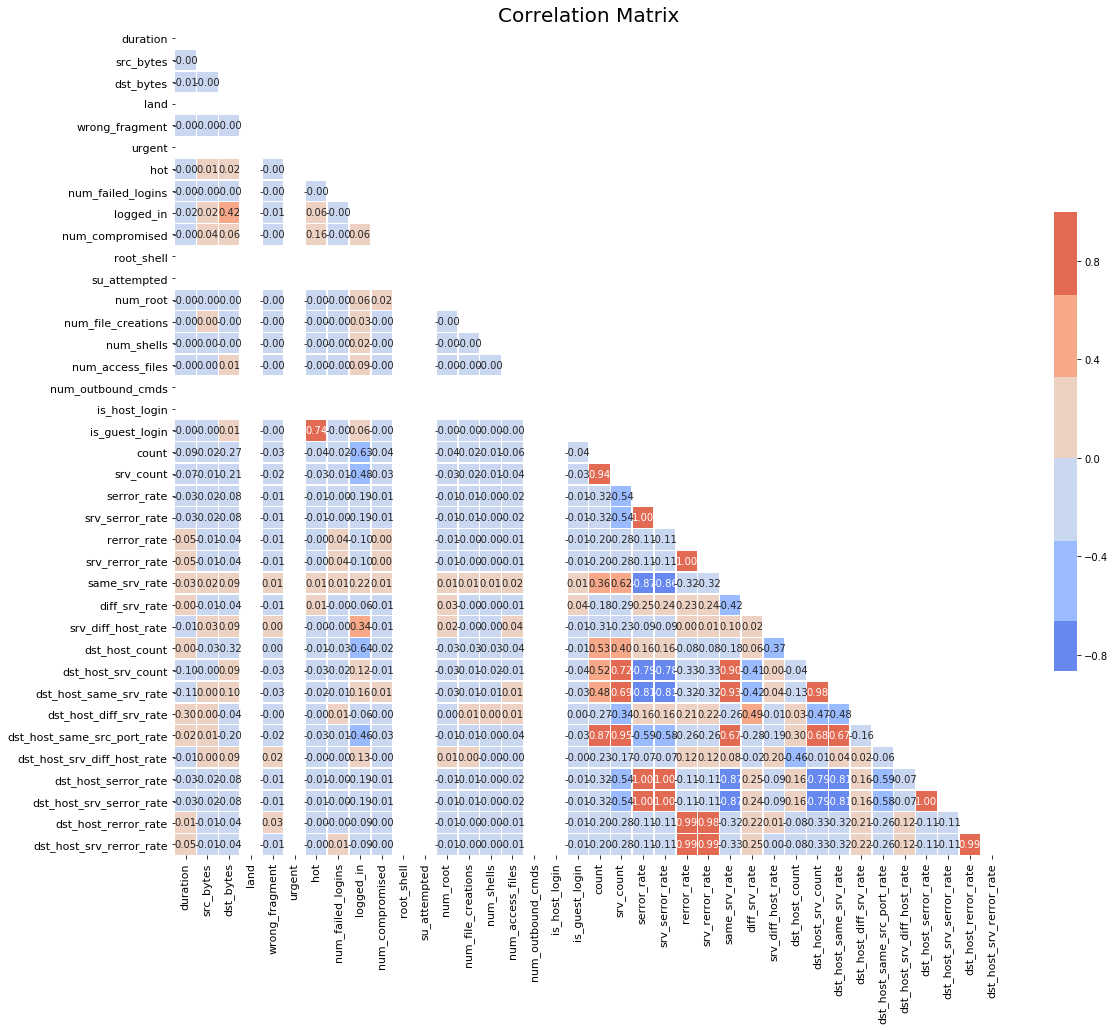

In [351]:
title = 'Correlation Matrix of data before Transformation'
pltfuncs.corr_heat(df)

In [441]:
top_correlations = tics.get_top_correlations(df, .6, -.6)
top_correlations

{('count', 'dst_host_same_src_port_rate'): 0.8628007590773243,
 ('dst_host_rerror_rate', 'dst_host_srv_rerror_rate'): 0.9870956101085416,
 ('dst_host_rerror_rate', 'srv_rerror_rate'): 0.9856208704310007,
 ('dst_host_same_src_port_rate', 'dst_host_same_srv_rate'): 0.6760553783171815,
 ('dst_host_same_src_port_rate', 'dst_host_srv_count'): 0.6843026927237744,
 ('dst_host_same_src_port_rate', 'same_srv_rate'): 0.6682268915700987,
 ('dst_host_same_src_port_rate', 'srv_count'): 0.947069601599306,
 ('dst_host_same_srv_rate', 'dst_host_srv_count'): 0.9792024459183125,
 ('dst_host_same_srv_rate', 'srv_count'): 0.6946381599629725,
 ('dst_host_serror_rate', 'dst_host_srv_serror_rate'): 0.9983845575231807,
 ('dst_host_serror_rate', 'serror_rate'): 0.9989889705141974,
 ('dst_host_serror_rate', 'srv_serror_rate'): 0.9980743508066214,
 ('dst_host_srv_count', 'same_srv_rate'): 0.9076117264942227,
 ('dst_host_srv_count', 'srv_count'): 0.720400477557647,
 ('dst_host_srv_rerror_rate', 'srv_rerror_rate')

In [442]:
df.label.value_counts()

smurf.              400720
neptune.            153505
normal.             139294
satan.                2265
ipsweep.              1792
portsweep.            1450
nmap.                  326
back.                  296
warezclient.           154
teardrop.              134
pod.                    40
guess_passwd.            9
buffer_overflow.         5
ftp_write.               2
warezmaster.             2
land.                    2
perl.                    1
rootkit.                 1
imap.                    1
loadmodule.              1
Name: label, dtype: int64

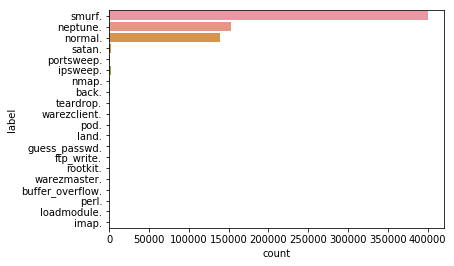

In [443]:
sns_plt = sns.countplot(y=df["label"])

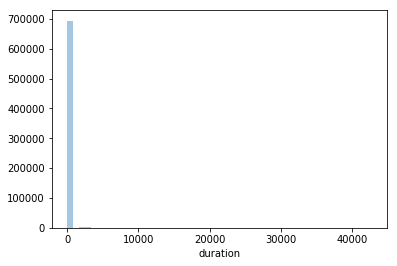

In [444]:
sns_plt = sns.distplot(df["duration"], kde=False)


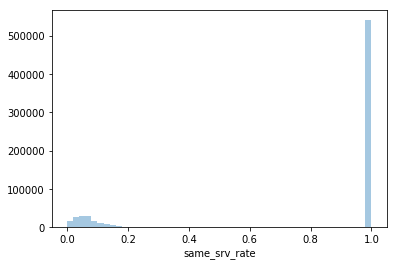

In [445]:
sns_plt = sns.distplot(df["same_srv_rate"], kde=False)

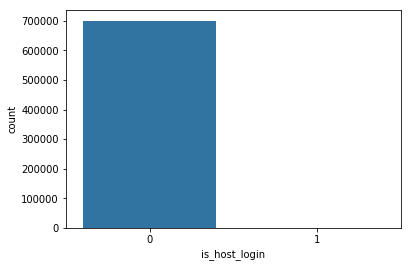

In [446]:
sns_plt = sns.countplot(x=df["is_host_login"])

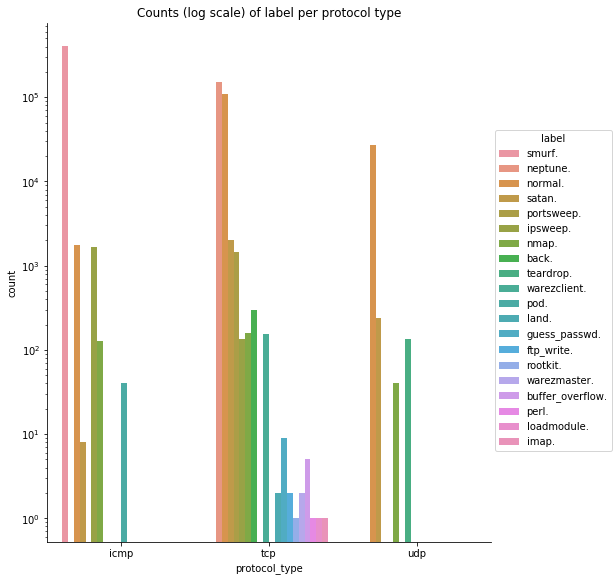

In [447]:
g = sns.factorplot(x='protocol_type', 
                         hue='label',
                         data=df,
                         kind='count',
                         size=8,

                         aspect=.9)

title = ['Counts (log scale) of label per protocol type']
for ax, title in zip(g.axes.flat, title):
    ax.set_title(title)
    ax.set(yscale="log")

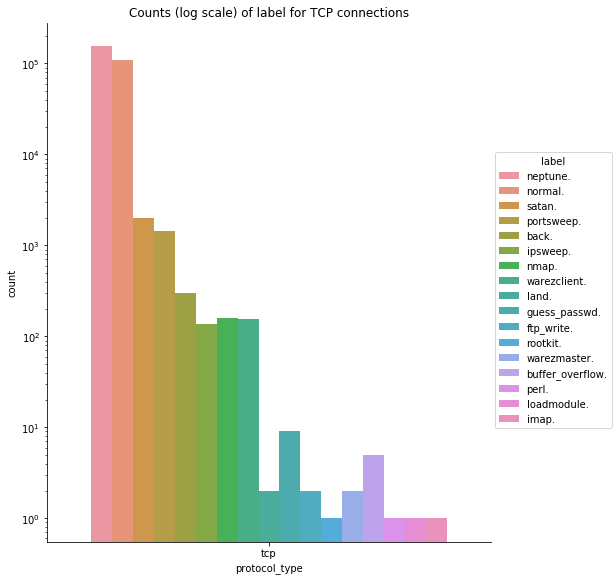

In [448]:
x = 'tcp'
hue = 'label'
col_name = 'protocol_type'
title = ['Counts (log scale) of label for TCP connections']

pltfuncs.log_label_for_factor_plot(df, col_name, x, hue, title)

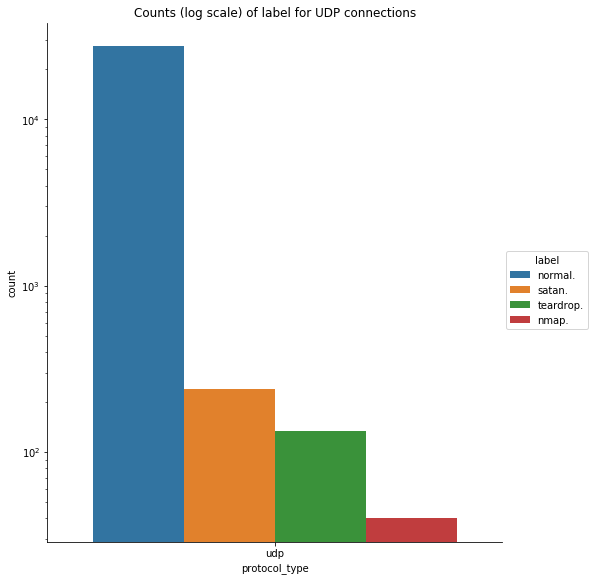

In [449]:
x = 'udp'
hue = 'label'
col_name = 'protocol_type'
title = ['Counts (log scale) of label for UDP connections']
pltfuncs.log_label_for_factor_plot(df, col_name, x, hue, title)

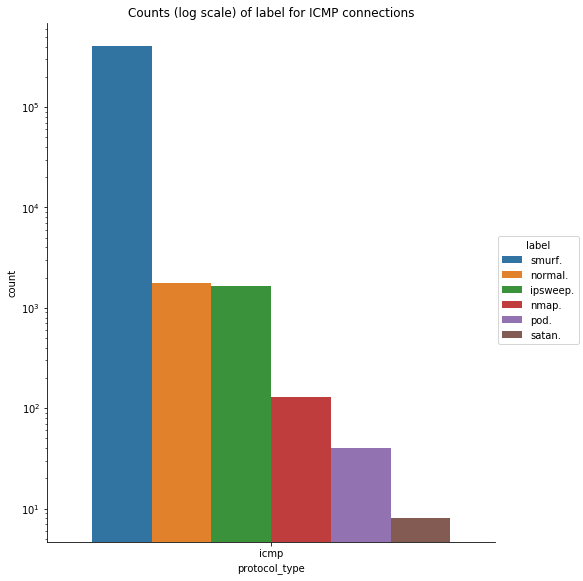

In [450]:
x = 'icmp'
hue = 'label'
col_name = 'protocol_type'
title = ['Counts (log scale) of label for ICMP connections']

pltfuncs.log_label_for_factor_plot(df, col_name, x, hue, title)

Note the large amount of Smurf attacks over ICMP protocol:

Smurf is a DDOS attack where large numbers of ICMP packets are broadcast to a computer network using the IP's broadcast address.  In the late 1990s, many IP networks would participate in Smurf attacks by responding to ICMP requests. The name comes from the idea of very small, but numerous, attackers overwhelming a much larger opponent 

### Categories of Attacks
- normal: (0) no attack occurred

Attacks fall into four main categories:
- probe: (1)surveillance and other probing, e.g., port scanning.
- DOS  : (2) denial-of-service, e.g. syn flood;
- U2R  : (3) unauthorized access to local superuser (root) privileges, e.g., various `buffer overflow` attacks;
- R2L  : (4) unauthorized access from a remote machine, e.g. guessing password;




Additionally, there are attack labels in the Test data that are different from the labels in the Training data.

##### Mapping for Attacks to Categories
(thanks to https://cseweb.ucsd.edu/~elkan/tabulate.html)



##### normal connection


| label   |        |Category #|
|--------|--------|----------|
|normal. | normal |(0)       |


##### attack types in testing data

| label   | Attack Type | Category # |
|--------|-------------|------------|
|apache2. | DOS |(2)| 
|back. | DOS |(2)| 
|buffer_overflow. | U2R |(3)| 
|ftp_write. |  R2L |(4)| 
|guess_passwd. |  R2L |(4)| 
|httptunnel. |  R2L |(4)| 
|httptunnel. | U2R |(3)| 
|imap. |  R2L |(4)| 
|ipsweep. | probe |(1)| 
|land. | DOS |(2)| 
|loadmodule. | U2R |(3)| 
|mailbomb. | DOS |(2)| 
|mscan. | probe |(1)| 
|multihop. |  R2L |(4)| 
|multihop. | U2R |(3)| # duplicate
|named. |  R2L |(4)| 
|neptune. | DOS |(2)| 
|nmap. | probe |(1)| 
|perl. | U2R |(3)| 
|phf. |  R2L |(4)| 
|pod. | DOS |(2)| 
|portsweep. | probe |(1)| 
|processtable. | DOS |(2)| 
|ps. | U2R |(3)| 
|rootkit. | U2R |(3)| 
|saint. | probe |(1)| 
|satan. | probe |(1)| 
|sendmail. |  R2L |(4)| 
|smurf. | DOS |(2)| 
|snmpgetattack. |  R2L |(4)| 
|snmpguess. |  R2L |(4)| 
|sqlattack. | U2R |(3)| 
|teardrop. | DOS |(2)| 
|udpstorm. | DOS |(2)| 
|warezmaster. | DOS |(2)| 
|worm. |  R2L |(4)| 
|xlock. |  R2L |(4)| 
|xsnoop. |  R2L |(4)| 
|xterm. | U2R |(3)|




##### attack types in training data

|label   | Attack Type | Category # |
|--------|-------------|------------|
|back. | DOS |(2)| 
|buffer_overflow. | U2R |(3)| 
|ftp_write. |  R2L |(4)| 
|guess_passwd. |  R2L |(4)| 
|imap. |  R2L |(4)| 
|ipsweep. | probe |(1)| 
|land. | DOS |(2)| 
|loadmodule. | U2R |(3)| 
|multihop. |  R2L |(4)| 
|neptune. | DOS |(2)| 
|nmap. | probe |(1)| 
|perl. | U2R |(3)| 
|phf. |  R2L |(4)| 
|pod. | DOS |(2)| 
|portsweep. | probe |(1)| 
|rootkit. | U2R |(3)| 
|satan. | probe |(1)| 
|smurf. | DOS |(2)| 
|spy. |  R2L |(4)| 
|teardrop. | DOS |(2)| 
|warezclient. |  R2L |(4)| 


## Transforming data

### putting labels into their categories, categorical number
- Normal : 0
- probe: 1
- DOS : 2
- U2R : 3
- R2L : 4

Considering the inconsistency between the test and train data, where multihop is U2R in the former and R2L in the latter, I have opted to consider it as 

In [457]:
# read in label names csv and send it as dictionary to mapping function
label_names = ['label', 'attack_category', 'attack_cat_num']
labels_loc = 'data/categories.csv'
labels_to_categories = pd.read_csv(labels_loc, header=None)
labels_to_categories.columns = label_names
col_name = 'label'
new_col_name = 'attack_category'

df2 = trans.rewrite_values(df, dict(zip(labels_to_categories.label, labels_to_categories.attack_cat_num)), col_name, new_col_name)
df2['attack_category'].value_counts()

2    554699
0    139294
1      5833
4       166
3         8
Name: attack_category, dtype: int64

In [458]:
df2['attack_category'].value_counts()

2    554699
0    139294
1      5833
4       166
3         8
Name: attack_category, dtype: int64

### changing protocols to categorical number

In [459]:
df2['protocol_type'].value_counts()

icmp    404318
tcp     267832
udp      27850
Name: protocol_type, dtype: int64

In [460]:
column_name = 'protocol_type'
mapping = list(df2[column_name].unique())

df3 = trans.my_create_dummies(df2, mapping, column_name)


In [461]:
df3.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,attack_category,icmp,tcp,udp
0,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,smurf.,2,1,0,0
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,smurf.,2,1,0,0
2,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.0,0.0,1.0,1.0,neptune.,2,0,1,0
3,2,tcp,finger,SF,8,138,0,0,0,0,...,0.00,0.0,0.0,0.0,0.0,normal.,0,0,1,0
4,0,tcp,ftp_data,SF,1030,0,0,0,0,0,...,0.04,0.0,0.0,0.0,0.0,normal.,0,0,1,0


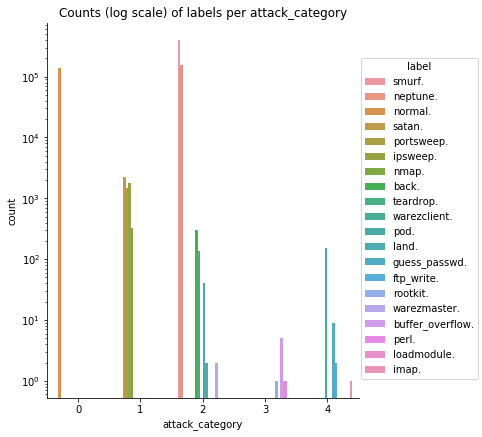

In [462]:
# split labels into separate plots per attack category
g = sns.factorplot(x='attack_category', 
                         hue='label',
                         data=df3,
                         kind='count',
                         size=6,

                         aspect=.9
                        )
title = ['Counts (log scale) of labels per attack_category']
for ax, title in zip(g.axes.flat, title):
    ax.set_title(title)
    ax.set(yscale="log")

```
Normal : 0
probe: 1
DOS : 2
U2R : 3
R2L : 4
```

TODO: create plots of services per attack category

**Counts of labels per attack category**

In [468]:
# Normal, category 0, indicates no attack
attack_cat0 = df3[(df3.attack_category == 0)]
attack_cat0['label'].value_counts()

normal.    139294
Name: label, dtype: int64

In [469]:
print('Probe : category 1')
attack_cat1 = df3[(df3.attack_category == 1)]
attack_cat1['label'].value_counts()

Probe : category 1


satan.        2265
ipsweep.      1792
portsweep.    1450
nmap.          326
Name: label, dtype: int64

In [470]:
print('DOS (Denial of Service) : category 2')
attack_cat2 = df3[(df3.attack_category == 2)]
attack_cat2['label'].value_counts()

DOS (Denial of Service) : category 2


smurf.          400720
neptune.        153505
back.              296
teardrop.          134
pod.                40
land.                2
warezmaster.         2
Name: label, dtype: int64

In [471]:
print('U2R (Unauthorized access to root) : category 3')
attack_cat3 = df3[(df3.attack_category == 3)]
attack_cat3['label'].value_counts()

U2R (Unauthorized access to root) : category 3


buffer_overflow.    5
rootkit.            1
loadmodule.         1
perl.               1
Name: label, dtype: int64

In [467]:
print('R2L (Unauthorized access from remote machine) : category 4')
attack_cat4 = df3[(df3.attack_category == 4)]
attack_cat3['label'].value_counts()

R2L (Unauthorized access from remote machine) : category 4


buffer_overflow.    5
rootkit.            1
loadmodule.         1
perl.               1
Name: label, dtype: int64

In [472]:
df3.attack_category.value_counts()

2    554699
0    139294
1      5833
4       166
3         8
Name: attack_category, dtype: int64

## Hypothesis Testing

#### Question: Are the proportions of connections that are attacks ( that fall into the attack category, not normal) consistent across protocol types?
- recall that `normal.` is not an attack.
- we will use the general category to get counts

From the graphics above, it seems likely that ICMP garners a higher proportion of attacks than TCP or UDP. We can perform a chi-squared test for proportions to check if there is a statistical difference.

- H0: the proportion of connections that are attacks is not significantly different between ICMP and TCP
- HA: the proportion of connections that are attacks is significantly different betwwen ICMP and TCP
- ALPHA = 0.05
- df = 1


**Determine the proportion of attacks/connection for each protocol_type**

In [473]:
print('total sample size: {}'.format(len(df3)))

# Set alpha
alpha = 0.05

total sample size: 700000


In [474]:
icmp_obs_attacks, icmp_obs_normal = hyp.get_attacks_proportion(df3, 'icmp')

Number of icmp Connections: 404318
Number of Attacks: 402552
Number Normal: 1766
Cat   Count
2    400760
1      1792
0      1766
Name: attack_category, dtype: int64


In [477]:
tcp_obs_attacks, tcp_obs_normal = hyp.get_attacks_proportion(df3, 'tcp')

Number of tcp Connections: 267832
Number of Attacks: 157741
Number Normal: 110091
Cat   Count
2    153805
0    110091
1      3762
4       166
3         8
Name: attack_category, dtype: int64


In [478]:
# for later
udp_obs_attacks, udp_obs_normal = hyp.get_attacks_proportion(df3, 'udp')

Number of udp Connections: 27850
Number of Attacks: 413
Number Normal: 27437
Cat   Count
0    27437
1      279
2      134
Name: attack_category, dtype: int64


## Test ICMP vs TCP attack proportion
- H0: the proportion of connections recorded that are attacks is not significantly different between ICMP and TCP
- HA: the proportion of connections recorded that are attacks is significantly different betwwen ICMP and TCP
- ALPHA = 0.05
- df = 1

**perform chi-square test for proportion**

In [479]:
from scipy.stats import chi2_contingency

# 
obs = np.array([[icmp_obs_attacks, icmp_obs_normal],[tcp_obs_attacks, tcp_obs_normal]])
chi2, p, dof, expected = chi2_contingency(obs)

In [483]:
print('total sample size: {}'.format(len(df3)))

if p < alpha:
    print('Reject H0, there is a significant difference in attack/connection proportion between ICMP and TCP ')
else:
    print('No significant difference between attack/connection proportion between ICMP and TCP ')
    
print('    chi-square\ntest statistic: {:.2f}\np-value       : {:.2f}\ndeg of freedom: {:.2f}\n'.format(chi2, p, dof))
print('Expected: \n{}'.format(expected))

total sample size: 700000
Reject H0, there is a significant difference in attack/connection proportion between ICMP and TCP 
    chi-square
test statistic: 192072.97
p-value       : 0.00
deg of freedom: 1.00

Expected: 
[[337032.72360931  67285.27639069]
 [223260.27639069  44571.72360931]]


## Test TCP vs UDP attack proportion
- H0: the proportion of connections recorded that are attacks is not significantly different between TCP and UDP
- HA: the proportion of connections recorded that are attacks is significantly different between TCP and UDP
- ALPHA = 0.05
- df = 1

**perform chi-square test for proportion**

In [484]:
obs = np.array([[udp_obs_attacks, udp_obs_normal],[tcp_obs_attacks, tcp_obs_normal]])
chi2, p, dof, expected = chi2_contingency(obs)

In [487]:
print('total sample size: {}'.format(len(df3)))

if p < alpha:
    print('Reject H0, there is a significant difference in attack/connection proportion between TCP and UDP ')
else:
    print('No significant difference between attack/connection proportion between TCP and UDP ')
    
print('    chi-square\ntest statistic: {:.2f}\np-value       : {:.2f}\ndeg of freedom: {:.2f}\n'.format(chi2, p, dof))
print('Expected: \n{}'.format(expected))

total sample size: 700000
Reject H0, there is a significant difference in attack/connection proportion between TCP and UDP 
    chi-square
test statistic: 33421.43
p-value       : 0.00
deg of freedom: 1.00

Expected: 
[[ 14896.37143959  12953.62856041]
 [143257.62856041 124574.37143959]]
